# <a id='toc1_'></a>[OpenAI 自學紀錄](#toc0_)

**目錄**<a id='toc0_'></a>    
- [OpenAI 自學紀錄](#toc1_)    
  - [建立簡易的 OpenAI Bot](#toc1_1_)    
    - [建立 OpenAI 對話](#toc1_1_1_)    
    - [建立簡易的對談程式](#toc1_1_2_)    
    - [記憶對話紀錄](#toc1_1_3_)    
    - [加入搜尋功能](#toc1_1_4_)    
  - [讓 AI 計算技術指標與資料視覺化](#toc1_2_)    
    - [AI 自動計算指標公式](#toc1_2_1_)    
    - [讓 AI 生成技術指標](#toc1_2_2_)    
      - [移動平均線 (Moving Average)](#toc1_2_2_1_)    
      - [指數平滑異同移動平均線 (MACD)](#toc1_2_2_2_)    
      - [相對強弱指標 (Relative Strength Index, RSI)](#toc1_2_2_3_)    
      - [布林通道 (Bollinger Bands)](#toc1_2_2_4_)    
      - [資料處理自動化](#toc1_2_2_5_)    
    - [資料視覺化](#toc1_2_3_)    
      - [加入成交量圖表](#toc1_2_3_1_)    
      - [加入技術指標](#toc1_2_3_2_)    
      - [繪製 K 線圖](#toc1_2_3_3_)    
      - [繪製其餘子圖](#toc1_2_3_4_)    
      - [繪製互動式 K 線圖](#toc1_2_3_5_)    
  - [AI 股票回測技術](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[建立簡易的 OpenAI Bot](#toc0_)

### <a id='toc1_1_1_'></a>[建立 OpenAI 對話](#toc0_)

In [5]:
from openai import OpenAI, OpenAIError
import getpass
import os

file_path = os.path.join(os.getcwd(), "Data", "openai_token")
with open(file_path, 'r') as file:
    api_key = file.read().strip()  # 去除空白字符
#api_key = getpass.getpass("請輸入金鑰：")
client = OpenAI(api_key=api_key)

reply = client.chat.completions.create(
    model = "gpt-3.5-turbo",
    messages = [
        {"role":"system", "content":"你是隻住在外太空的猴子"},
        {"role":"user", "content":"你住的地方很亮嗎？reply in 繁體中文"}
    ]
)

print(reply.choices[0].message.content)
print(f"本次的 token 用量為：{reply.usage.total_tokens}")

不，我住的地方其實很黑暗。外太空的夜晚沒有城市燈光，只有星星和宇宙中的光芒。這種黑暗讓我特別享受宇宙的寧靜。
本次的 token 用量為：130


### <a id='toc1_1_2_'></a>[建立簡易的對談程式](#toc0_)

In [8]:
def get_reply(messages):
    try:
        response = client.chat.completions.create(
            model= "gpt-3.5-turbo",
            messages= messages
        )
        reply = response.choices[0].message.content
    except OpenAIError as err:
        reply = f"發生 {err.type} 錯誤\n{err.message}"
    return reply

### <a id='toc1_1_3_'></a>[記憶對話紀錄](#toc0_)

In [7]:
history = []
backtrace = 2

def chat(sys_msg, user_msg):
    history.append({"role":"user", "content":user_msg})
    reply = get_reply(history + [{"role":"system", "content":sys_msg}])

    while len(history) >= 2 * backtrace:
        history.pop(0)  # 移除最舊紀錄
    history.append({"role":"assistant", "content":reply})
    return reply

In [10]:
sys_msg = input("你希望 AI 扮演：")
if not sys_msg.strip():
    sys_msg = "小助理"
print(f"你希望 AI 扮演：{sys_msg}\n")
while True:
    msg = input("你：")
    if not msg.strip():
        break
    reply = chat(sys_msg, msg)
    print(f"你：{msg}")
    print(f"{sys_msg}:{reply}\n")

history=[]

你希望 AI 扮演：地理大師

你：台灣在哪裡
地理大師:台灣位於亞洲東部的西北太平洋中，靠近菲律賓、中國大陸、日本和韓國。台灣的正式名稱是中華民國，首都是台北。

你：面積有多少
地理大師:台灣的總面積約為3.6萬平方公里。



### <a id='toc1_1_4_'></a>[加入搜尋功能](#toc0_)

In [24]:
from googlesearch import search

history = []
backtrace = 5

def chat_web(sys_msg, user_msg, is_search = True):
    web_res = []
    if is_search == True:
        content = "以下為已發生的事實：\n"
        for res in search(user_msg, advanced=True, num_results=5, lang='zh_TW'):
            content += f"標題:{res.title}\n摘要:{res.description}\n\n"
        content += "請依照上述事實回答問題 \n"
        web_res = [{"role":"user", "content": content}]
    web_res.append({"role":"user", "content":user_msg})

    while len(history) >= 2 * backtrace:
        history.pop(0)
    
    reply_full = ""

    for reply in get_reply(
        history         # 歷史訊息
        + web_res       # 目前訊息和搜尋結果
        + [{"role":"system", "content": sys_msg}]
    ):
        reply_full += reply     # 記錄目前收到的訊息
        yield reply     # 傳回本次收到的訊息
    history.append({"role":"user", "content":user_msg})

    while len(history) >= 2 * backtrace:
        history.pop(0)
    history.append({"role":"assistant", "content":reply_full})

In [28]:
sys_msg = "小助理"

while True:
    msg = input("你：")
    if not msg.strip():
        break
    print(f"你：{msg}")
    print(f"{sys_msg}: ", end="")
    for reply in chat_web(sys_msg, msg, is_search=True):
        print(reply, end="")
    print('\n')
history = []

你：2023 年的 NBA 冠軍是誰？ reply in 繁體中文
小助理: 2023年的NBA冠軍是丹佛金塊。



目前以上程式經測試後可以正確回答超出 GPT 資料蒐集時間的內容。

但在搜尋的部分**不會繼承記憶性**，目前打算的改法為：讓 chatgpt 總結關鍵的 token，再透過 search 得出結果，再將結果再次輸入 chatgpt

## <a id='toc1_2_'></a>[讓 AI 計算技術指標與資料視覺化](#toc0_)

### <a id='toc1_2_1_'></a>[AI 自動計算指標公式](#toc0_)

In [21]:
from openai import OpenAI, OpenAIError
import yfinance as yf
import pandas as pd
import datetime as dt

stock_id = "2330.tw"    # 台積電
end = dt.date.today()   # 資料結束時間
start = end - dt.timedelta(days=180)    # 資料開始時間
df = yf.download(stock_id, start=start, end=end).reset_index()

print(df)

[*********************100%%**********************]  1 of 1 completed

          Date   Open   High    Low  Close   Adj Close    Volume
0   2023-09-25  522.0  529.0  522.0  525.0  519.842834  17116402
1   2023-09-26  521.0  524.0  519.0  519.0  513.901733  26392692
2   2023-09-27  517.0  523.0  516.0  522.0  516.872253  16846401
3   2023-09-28  523.0  525.0  520.0  523.0  517.862427  19733331
4   2023-10-02  530.0  534.0  528.0  533.0  527.764221  25427911
..         ...    ...    ...    ...    ...         ...       ...
111 2024-03-14  779.0  785.0  770.0  784.0  780.355896  42010806
112 2024-03-15  771.0  777.0  753.0  753.0  749.500000  73316437
113 2024-03-18  754.0  765.0  754.0  764.0  764.000000  43589856
114 2024-03-19  758.0  765.0  755.0  762.0  762.000000  30152375
115 2024-03-20  764.0  769.0  752.0  758.0  758.000000  41280325

[116 rows x 7 columns]


In [6]:
client = OpenAI(api_key=api_key)

def ai_helper(df, user_msg):
    msg = [{
        "role": "system",
        "content": 
        f"As a professional code generation robot, \n\
        I require your assistance in generating Python code \n\
        based on specific user requirements. To proceed, \n\
        I will provide you with a dataframe (df) that follows the \n\
        format {df.columns}. Your task is to carefully analyze the\n\
        user's requirements and generate python code \n\
        accordingly. Please note that your response should solely \n\
        consist of the code itself,\n\
        and no additional information should be include."
    }, {
        "role": "user",
        "content":
        f"The user requirement:{user_msg} \n\
        Your task is to create a function named 'calculate(df)' \n\
        that takes a dataframe as input. The function should process \n\
        the dataframe and return only the processed dataframe. \n\
        Please ensure that your response includes the Python code \n\
        for the 'calculate(df)' function \n\
        and does not include any other content."
    }]
    reply_data = get_reply(msg)
    return reply_data

### <a id='toc1_2_2_'></a>[讓 AI 生成技術指標](#toc0_)

#### <a id='toc1_2_2_1_'></a>[移動平均線 (Moving Average)](#toc0_)

**移動平均線 (MA)**是一種最常見的技術指標，會將一定時間內的**收盤價**進行平均，根據不同的天數（週線 5 天、月線 20 天、季線 60 天）能夠反映短期、中期、長期的價格趨勢。

**指數移動平均 (EMA)** 則會給近期的價格更高的權重做加權平均。

In [60]:
# 避開 compiler 檢查
def calculate(df):
    pass

def ai_code_exec(df, instruction):
    code_str = ai_helper(df, instruction)
    print(code_str)

    # 將 exec 生成的 calculate 設為 local variable
    local_vars = {}
    # 執行 AI 產生的程式碼
    exec(code_str, globals(), local_vars)
    calculate = local_vars['calculate']

    new_df = df.copy()
    new_df = calculate(new_df)
    return new_df

new_df = ai_code_exec(df, "計算 8 日 MA 與 13 日 MA" )
# 這裡保險起見可能需要檢查 new_df
new_df.tail()

def calculate(df):
    df['8_MA'] = df['Close'].rolling(window=8).mean()
    df['13_MA'] = df['Close'].rolling(window=13).mean()
    return df


,Open,High,Low,Close,Adj Close,Volume,MACD Line,Signal Line,8_MA,13_MA
Date,,,,,,,,,,
2024-03-18,754.0,765.0,754.0,764.0,764.0,43589856,33.739481,33.454185,770.000,748.384615
2024-03-19,758.0,765.0,755.0,762.0,762.0,30152375,32.110159,33.185380,770.250,753.923077
2024-03-20,764.0,769.0,752.0,758.0,758.0,41280325,30.148609,32.578025,767.000,759.230769
2024-03-21,773.0,784.0,772.0,784.0,784.0,46026103,30.342282,32.130877,769.250,763.769231
2024-03-22,788.0,789.0,775.0,785.0,785.0,30660820,30.228011,31.750303,771.125,768.000000


#### <a id='toc1_2_2_2_'></a>[指數平滑異同移動平均線 (MACD)](#toc0_)

**MACD** 建立在 EMA 的基礎上，故 MACD 更在乎近期的價格趨勢。在技術分析中，MACD 柱狀圖可以看出股價趨勢是否反轉。可以觀察 MACD 柱狀圖**由負轉正**或**由正轉負**的時候，即為買賣的進出點

In [48]:
new_df = ai_code_exec(df, "計算 MACD, 欄位名稱用 'MACD Histogram' 命名")
new_df.tail()

def calculate(df):
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD Histogram'] = df['MACD'] - df['Signal_Line']
    
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,EMA_12,EMA_26,MACD,Signal_Line,MACD Histogram
111,2024-03-14,779.0,785.0,770.0,784.0,780.355896,42010806,747.975934,710.470696,37.505238,32.952416,4.552822
112,2024-03-15,771.0,777.0,753.0,753.0,749.500000,73316437,748.748868,713.621015,35.127853,33.387503,1.740349
113,2024-03-18,754.0,765.0,754.0,764.0,764.000000,43589856,751.095196,717.352792,33.742404,33.458483,0.283921
114,2024-03-19,758.0,765.0,755.0,762.0,762.000000,30152375,752.772858,720.659992,32.112866,33.189360,-1.076494
115,2024-03-20,764.0,769.0,752.0,758.0,758.000000,41280325,753.577034,723.425919,30.151115,32.581711,-2.430596


#### <a id='toc1_2_2_3_'></a>[相對強弱指標 (Relative Strength Index, RSI)](#toc0_)

**RSI 指標** 通常用來判斷市場是**超買**還是**超賣**，範圍介於 0 ~ 100 之間。當 RSI 大於 70 ~ 80 時，代表目前可能被過度買入。而 RSI 小於 20 ~ 30 時，則代表可能被過度賣出。我們可以使用 RSI 指標來判斷否出現反轉訊號

$RSI = \displaystyle \frac{漲幅平均值}{漲幅平均值 + |跌幅平均值|}$，取一段時間。

In [47]:
new_df = ai_code_exec(df, "計算 RSI 指標")
new_df.tail()

def calculate(df):
    delta = df['Close'].diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)

    avg_gain = gain.ewm(span=14, min_periods=14).mean()
    avg_loss = loss.ewm(span=14, min_periods=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df


,Date,Open,High,Low,Close,Adj Close,Volume,RSI
111,2024-03-14,779.0,785.0,770.0,784.0,780.355896,42010806,79.503621
112,2024-03-15,771.0,777.0,753.0,753.0,749.500000,73316437,55.511496
113,2024-03-18,754.0,765.0,754.0,764.0,764.000000,43589856,60.403808
114,2024-03-19,758.0,765.0,755.0,762.0,762.000000,30152375,59.041703
115,2024-03-20,764.0,769.0,752.0,758.0,758.000000,41280325,56.121243


#### <a id='toc1_2_2_4_'></a>[布林通道 (Bollinger Bands)](#toc0_)

**布林通道**主要由移動平均線、上軌線與下軌線組合，中間會形成一個通道。
通道的兩端分別代表**買入或賣出的壓力**線，當股價觸及上軌線時，可以視為**賣出訊號**；反之，則為**買入訊號**。

In [46]:
new_df = ai_code_exec(df, "請計算 1.5 個標準差的布林通道， 欄位以 'Upper Band' 和 'Lower Band' 命名")
new_df.tail()

def calculate(df):
    df['Middle Band'] = df['Close'].rolling(window=20).mean()
    df['STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['Middle Band'] + 1.5 * df['STD']
    df['Lower Band'] = df['Middle Band'] - 1.5 * df['STD']
    
    return df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Upper Band', 'Lower Band']]


,Date,Open,High,Low,Close,Adj Close,Volume,Upper Band,Lower Band
111,2024-03-14,779.0,785.0,770.0,784.0,780.355896,42010806,779.373588,662.926412
112,2024-03-15,771.0,777.0,753.0,753.0,749.500000,73316437,782.451974,665.448026
113,2024-03-18,754.0,765.0,754.0,764.0,764.000000,43589856,786.094750,669.905250
114,2024-03-19,758.0,765.0,755.0,762.0,762.000000,30152375,788.538825,675.861175
115,2024-03-20,764.0,769.0,752.0,758.0,758.000000,41280325,790.349469,681.150531


#### <a id='toc1_2_2_5_'></a>[資料處理自動化](#toc0_)

In [45]:
df_monthly = ai_code_exec(df,  "請將日K線資料轉換成月K線")
df_monthly.tail()

def calculate(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df_monthly = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Adj Close': 'last',
        'Volume': 'sum'
    })
    return df_monthly


<string>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-30,533.0,585.0,527.0,577.0,571.331970,531342183
2023-12-31,573.0,593.0,566.0,593.0,590.243713,565572937
2024-01-31,590.0,648.0,574.0,628.0,625.080994,801241408
2024-02-29,625.0,709.0,619.0,690.0,686.792847,563384426
2024-03-31,697.0,796.0,688.0,758.0,758.000000,769274636


### <a id='toc1_2_3_'></a>[資料視覺化](#toc0_)

In [23]:
import matplotlib.pyplot as plt

new_df = df.copy()
new_df = new_df.reset_index()
# 將 Date 轉換成 datetime 類別
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume
111,111,2024-03-14,779.0,785.0,770.0,784.0,780.355896,42010806
112,112,2024-03-15,771.0,777.0,753.0,753.0,749.500000,73316437
113,113,2024-03-18,754.0,765.0,754.0,764.0,764.000000,43589856
114,114,2024-03-19,758.0,765.0,755.0,762.0,762.000000,30152375
115,115,2024-03-20,764.0,769.0,752.0,758.0,758.000000,41280325


<function matplotlib.pyplot.show(close=None, block=None)>

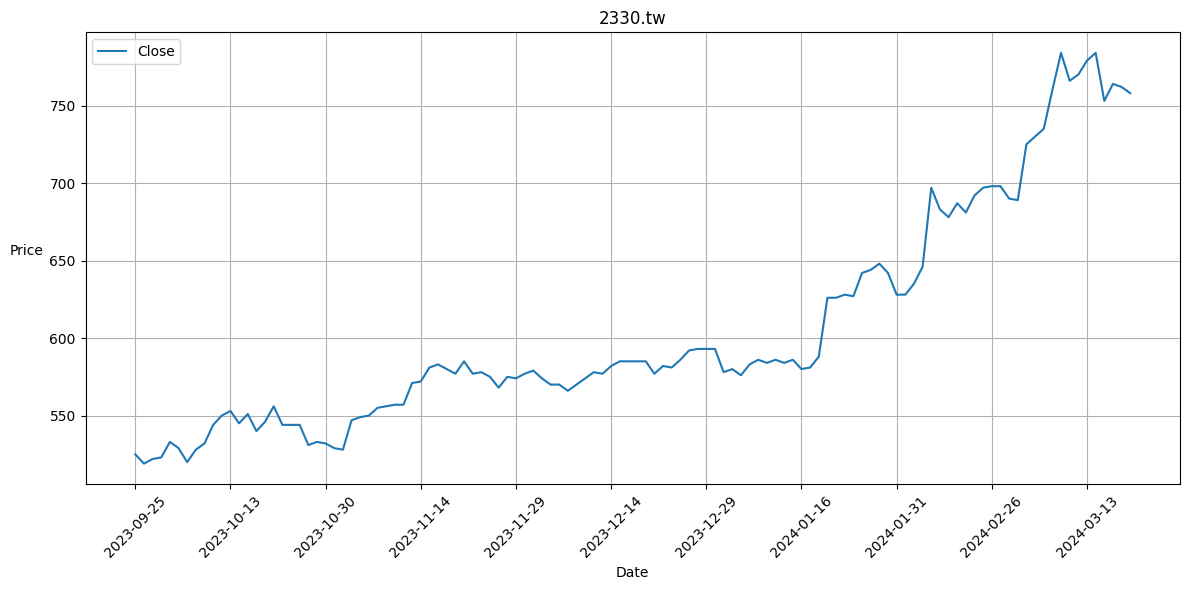

In [26]:
plt.figure(figsize=(12, 6))

# 設定收盤價為要繪製的資料欄位
plt.plot(new_df['Close'], label='Close')

# 設定 x 軸的時間
num = 10    # 設定顯示幾筆時間標籤
date = new_df['Date'].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index, date[::len(date)//num], rotation=45)

# 設定圖表資訊
plt.title(f'{stock_id}')
plt.xlabel('Date')
plt.ylabel('Price', rotation=0, ha='right')
plt.legend(loc='upper left')    # 將圖例顯示於左上角
plt.grid(True)  # 顯示網格
plt.tight_layout()

plt.show

#### <a id='toc1_2_3_1_'></a>[加入成交量圖表](#toc0_)

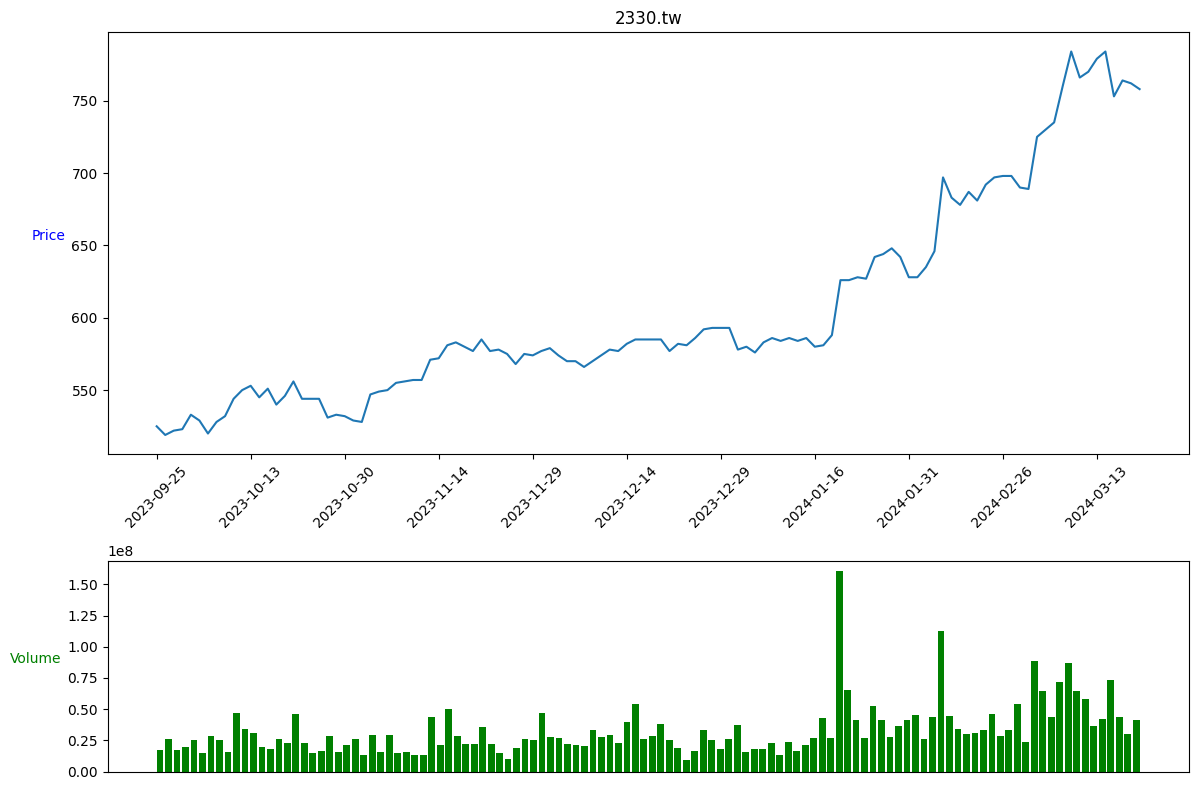

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, 
                              figsize=(12, 8), 
                              gridspec_kw={'height_ratios':[2, 1]})

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num], rotation=45)

# 繪製成交量
ax2.bar(new_df.index, new_df['Volume'], color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')
ax2.set_xticks([])  # 不顯示日期標籤

# 讓子圖填充、對齊
plt.tight_layout()

plt.show()

#### <a id='toc1_2_3_2_'></a>[加入技術指標](#toc0_)

def calculate(df):
    df['Upper_Band'] = df['Close'].rolling(window=20).mean() + 1.5 * df['Close'].rolling(window=20).std()
    df['Lower_Band'] = df['Close'].rolling(window=20).mean() - 1.5 * df['Close'].rolling(window=20).std()
    
    shortEMA = df['Close'].ewm(span=12, adjust=False).mean()
    longEMA = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = shortEMA - longEMA
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    return df


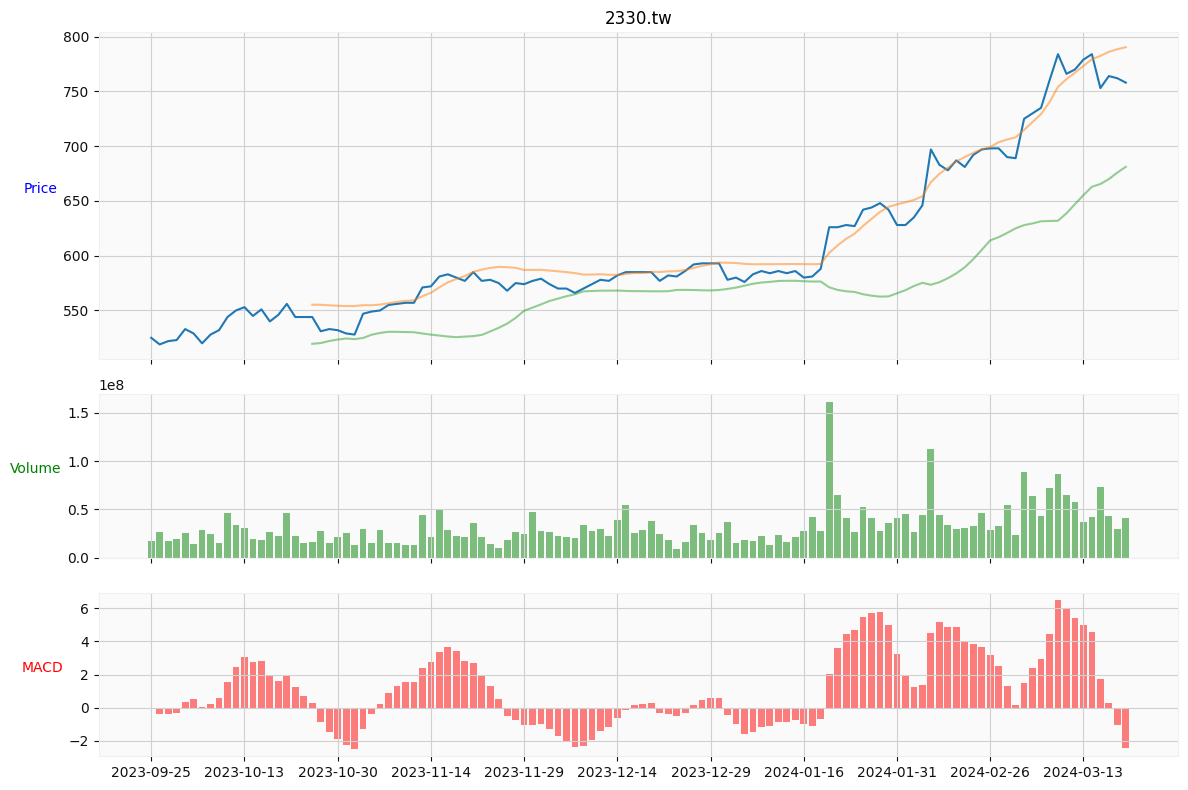

In [44]:
# 初始化
new_df = ai_code_exec(df, "請計算 1.5 個標準差的布林通道， 欄位以 'Upper_Band' 和 'Lower_Band' 命名。\n\
                    計算 MACD, 欄位名稱用 'MACD_Histogram' 命名")


# 創立子圖
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    figsize=(12, 8),
                                    gridspec_kw={'height_ratios': [2, 1, 1]},
                                    sharex=True)

# 設定 x 軸時間
num = 10
date = new_df['Date'].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
# 加入布林通道
ax1.plot(new_df['Upper_Band'], alpha=0.5)   # alpha = 透明度
ax1.plot(new_df['Lower_Band'], alpha=0.5)
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num])

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'], alpha=0.5, color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')

# 繪製技術指標
ax3.bar(new_df.index, new_df['MACD_Histogram'], alpha=0.5, color='red')
ax3.set_ylabel('MACD', color='red', rotation=0, ha='right')

# 縮短子圖的距離
plt.tight_layout()

plt.show()

#### <a id='toc1_2_3_3_'></a>[繪製 K 線圖](#toc0_)

使用 **mplfinance** 套件


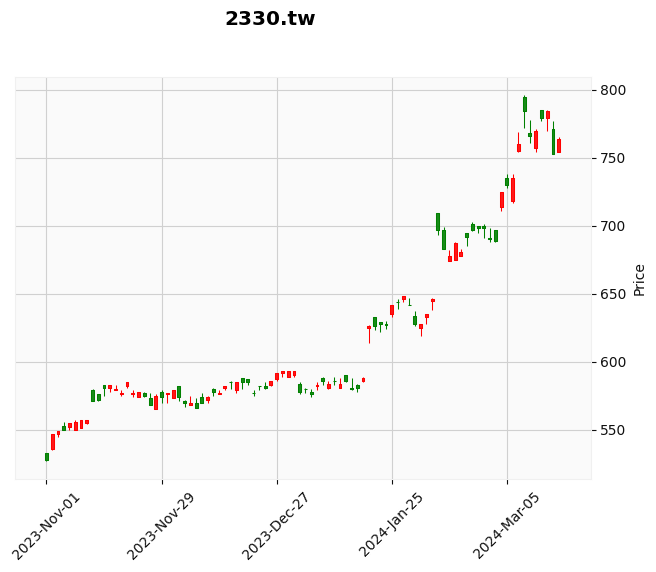

In [41]:
import mplfinance as mpf

kplot_df = new_df.copy().set_index('Date')
kplot_df = kplot_df['2023-11-01':'2024-03-18']
kplot_df.tail()

# 設置繪圖風格
color = mpf.make_marketcolors(up='r', down='g', inherit=True)
style = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=color)

mpf.plot(kplot_df, type='candle', style=style, title=f'{stock_id}')

#### <a id='toc1_2_3_4_'></a>[繪製其餘子圖](#toc0_)

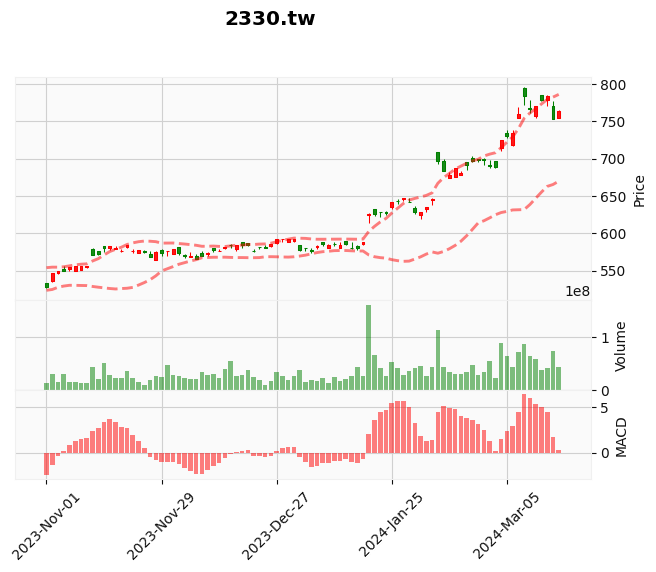

In [42]:
ap = [
    # 上軌線
    mpf.make_addplot(kplot_df['Upper_Band'], color='red', alpha=0.5, linestyle='--'),
    # 下軌線
    mpf.make_addplot(kplot_df['Lower_Band'], color='red', alpha=0.5, linestyle='--'),
    # 成交量
    # 設定 panel=1，代表第二個子圖
    mpf.make_addplot(kplot_df['Volume'], panel=1, type='bar', color='g', alpha=0.5, ylabel='Volume'),
    # MACD
    mpf.make_addplot(kplot_df['MACD_Histogram'], panel=2, type='bar', color='r', alpha=0.5, ylabel='MACD')
]

mpf.plot(kplot_df, type='candle', addplot=ap, style=style, title=f'{stock_id}')

#### <a id='toc1_2_3_5_'></a>[繪製互動式 K 線圖](#toc0_)

## <a id='toc1_3_'></a>[AI 股票回測技術](#toc0_)

### 何為股票回測？

簡單來說，**股票回測** 就是使用歷史資料來進行**模擬交易**

- 假設我們有一個短線 SMA 穿越長線 SMA 的策略，要如何評估這個策略是否會賺錢？
  - 建立一個**虛擬帳戶**
  - 設定初始資金
  - 設定每次的下單量

In [49]:
from openai import OpenAI, OpenAIError
import yfinance as yf
import pandas as pd
import datetime as dt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

stock_id = "2330.tw"

df = yf.download(stock_id, period='5y')
# 計算指標
df['ma1'] = df['Close'].rolling(window=5).mean()
df['ma2'] = df['Close'].rolling(window=10).mean()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma1,ma2
Date,,,,,,,,
2019-03-22,248.0,248.5,244.5,248.5,215.986206,22931467,NaN,NaN
2019-03-25,240.5,243.5,240.5,241.5,209.902084,19211254,NaN,NaN
2019-03-26,243.0,244.0,241.0,244.0,212.074951,19920170,NaN,NaN
2019-03-27,242.0,242.5,240.5,241.5,209.902084,22590089,NaN,NaN
2019-03-28,240.5,242.5,240.0,242.0,210.336655,13933054,243.5,NaN


In [52]:
class CrossStrategy(Strategy):
    def init(self):
        super().init()

    def next(self):
        if crossover(self.data.ma1, self.data.ma2):
            self.buy(size=1)
        elif crossover(self.data.ma2, self.data.ma1):
            self.sell(size=1)
    
backtest = Backtest(df,
                    CrossStrategy,
                    cash=1000000,
                    commission=0.004,       # 手續費
                    margin=1,               # 槓桿比例
                    hedging=False,          # 當沖交易
                    trade_on_close=False,   # 依收盤價買賣
                    exclusive_orders=False
                    )
stats = backtest.run()

print(stats)

# 查看詳細的交易紀錄
stats["_trades"].head()

Start                     2019-03-22 00:00:00
End                       2024-03-22 00:00:00
Duration                   1827 days 00:00:00
Exposure Time [%]                   74.938373
Equity Final [$]                   999913.328
Equity Peak [$]                   1000485.818
Return [%]                          -0.008667
Buy & Hold Return [%]              215.895372
Return (Ann.) [%]                   -0.001795
Volatility (Ann.) [%]                0.019686
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.057221
Avg. Drawdown [%]                   -0.006565
Max. Drawdown Duration      514 days 00:00:00
Avg. Drawdown Duration       77 days 00:00:00
# Trades                                   64
Win Rate [%]                          42.1875
Best Trade [%]                      35.820355
Worst Trade [%]                    -20.240412
Avg. Trade [%]                    

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-1,26,50,260.454,238.0,22.454,0.086211,2019-05-02,2019-06-05,34 days
1,-1,60,63,241.032,241.0,0.032,0.000133,2019-06-20,2019-06-25,5 days
2,-1,67,70,244.518,244.5,0.018,0.000074,2019-07-01,2019-07-04,3 days
3,-1,75,76,249.000,252.0,-3.000,-0.012048,2019-07-11,2019-07-12,1 days
4,-1,91,103,250.992,254.5,-3.508,-0.013977,2019-08-02,2019-08-21,19 days


#### 繪製回測圖表

In [51]:
backtest.plot(plot_equity=True,      # 資金變化圖
              plot_return=False,     # 報酬率變化圖
              plot_pl=True,          # 損益圖表
              plot_volume=True,      # 交易量
              plot_drawdown=False,   # 最大損失圖
              superimpose=True       # 顯示月K線
              )

/Users/yusung/Desktop/Computer_Science/AI_Project/ai_project/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/yusung/Desktop/Computer_Science/AI_Project/ai_project/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/yusung/Desktop/Computer_Science/AI_Project/ai_project/lib/python3.11/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
/Users/yusung/Desktop/Computer_Science/AI_Project/ai_project/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'to

GridPlot(id='p1305', ...)

#### 加入停利、停損策略

- **停損點**：先設置好一個股票下跌時的價格水位，當股票觸碰到該價格時，就賣出股票，進而避免損失擴大。
- **停利點**：先設置好一個股票上漲時的價格水位，當股票觸碰到該價格時，就賣出股票，進而鎖定利潤，避免市場反轉帶來的風險

In [56]:
class CrossStrategy(Strategy):
    def init(self):
        super().init()

    def next(self):
        if crossover(self.data.ma1, self.data.ma2):
            self.buy(size=1,
                     sl=self.data.Close[-1] * 0.90,     # 停損價格
                     tp=self.data.Close[-1] * 1.10      # 停利價格
                     )
        elif crossover(self.data.ma2, self.data.ma1):
            self.sell(size=1,
                      sl=self.data.Close[-1] * 1.10,    # 停損價格
                      tp=self.data.Close[-1] * 0.90     # 停利價格
                      )
            
backtest = Backtest(df,
                    CrossStrategy,
                    cash=1000000,
                    commission=0.004,       # 手續費
                    margin=1,               # 槓桿比例
                    hedging=False,          # 當沖交易
                    trade_on_close=False,   # 依收盤價買賣
                    exclusive_orders=False
                    )
stats = backtest.run()
print(stats)

Start                     2019-03-22 00:00:00
End                       2024-03-22 00:00:00
Duration                   1827 days 00:00:00
Exposure Time [%]                   52.999178
Equity Final [$]                   999933.118
Equity Peak [$]                    1000067.09
Return [%]                          -0.006688
Buy & Hold Return [%]              215.895372
Return (Ann.) [%]                   -0.001385
Volatility (Ann.) [%]                0.008706
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.036862
Avg. Drawdown [%]                   -0.005559
Max. Drawdown Duration     1279 days 00:00:00
Avg. Drawdown Duration      158 days 00:00:00
# Trades                                   71
Win Rate [%]                        33.802817
Best Trade [%]                      14.218451
Worst Trade [%]                    -12.260064
Avg. Trade [%]                    